Multinomial Logistic Regression for Mineral Classification. 

## 1. Data Preparation

### 1.1 Data Preprocessing and Exploration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Check for Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Check for Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Openpyxl
import openpyxl

# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from numpy.random import RandomState
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics 
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2

# Make notebook output stable across runs
np.random.seed(42)

In [13]:
train = pd.read_csv('/content/drive/MyDrive/Capstone datasets/trainsplit2.csv', header=0)
test = pd.read_csv('/content/drive/MyDrive/Capstone datasets/testsplit2.csv', header=0)
validation = pd.read_csv('/content/drive/MyDrive/Capstone datasets/valsplit2.csv', header=0)

In [14]:
train.head()

,Index,x,y,Ag_counts,Al_counts,As_counts,Au_counts,Ba_counts,Bi_counts,Ca_counts,...,Ti_counts,Tl_counts,U_counts,V_counts,W_counts,Y_counts,Zn_counts,Zr_counts,z,Mineralogy
0,1091007,16000,2400,0.5,20.0,0.5,2.0,0.5,13.0,247.0,...,2162.0,0.5,4.0,140.0,13.0,12.0,0.5,12.0,3600.0,Ilmenite
1,1027436,43600,24400,0.5,0.5,0.5,0.5,0.5,6.0,2.0,...,271.0,8.0,9.0,11.0,0.5,0.5,0.5,11.0,5400.0,Ilmenite
2,1509293,3400,3400,1.0,2.0,0.5,0.5,0.5,0.5,16.0,...,3605.0,0.5,0.5,220.0,30.0,0.5,16.0,7.0,8400.0,Rutile
3,793374,15000,1600,9.0,0.5,0.5,18.0,0.5,14.0,8.0,...,20.0,15.0,16.0,0.5,0.5,0.5,0.5,0.5,12000.0,Fe oxide
4,813186,23000,22000,0.5,12.0,0.5,5.0,9.0,6.0,328.0,...,69.0,0.5,6.0,6.0,0.5,0.5,0.5,0.5,10000.0,Epidote


In [15]:
# Counts of unique minerals in the train dataset:
train['Mineralogy'].value_counts()

Epidote                247533
Hornblende             240735
Titanite               212871
Ilmenite               125317
Fe oxide               116051
Rutile                 110948
Fe-silicate             35923
Fe Al-silicate          23935
Al silicate             19873
Quartz                  17719
Amphibole               17019
Orthopyroxene           16607
Apatite                 14793
Biotite                 12666
Almandine                5776
REE silicate             3864
MnFe oxide               3752
Barite                   3564
Zircon                   2894
Mn oxide                 2053
Monazite                 1721
Chloritoid               1050
Fe silicate               917
Uvite (tourmaline)        777
Ancylite                  366
YFe-silicate              320
Carbonate                 258
Xenotime                  220
Thorite                   174
Ferberite (W oxide)        89
Cassiterite                50
Zn_Fe_Al_silicate?         43
Arsenopyrite               42
Perovskite

In [16]:
# Minerals as a percentage of the train dataset 
train['Mineralogy'].value_counts(normalize=True)*100

Epidote                19.959812
Hornblende             19.411655
Titanite               17.164843
Ilmenite               10.104930
Fe oxide                9.357767
Rutile                  8.946287
Fe-silicate             2.896649
Fe Al-silicate          1.929998
Al silicate             1.602458
Quartz                  1.428771
Amphibole               1.372326
Orthopyroxene           1.339105
Apatite                 1.192833
Biotite                 1.021322
Almandine               0.465747
REE silicate            0.311573
MnFe oxide              0.302542
Barite                  0.287383
Zircon                  0.233358
Mn oxide                0.165544
Monazite                0.138773
Chloritoid              0.084667
Fe silicate             0.073942
Uvite (tourmaline)      0.062653
Ancylite                0.029512
YFe-silicate            0.025803
Carbonate               0.020804
Xenotime                0.017740
Thorite                 0.014030
Ferberite (W oxide)     0.007177
Cassiterit

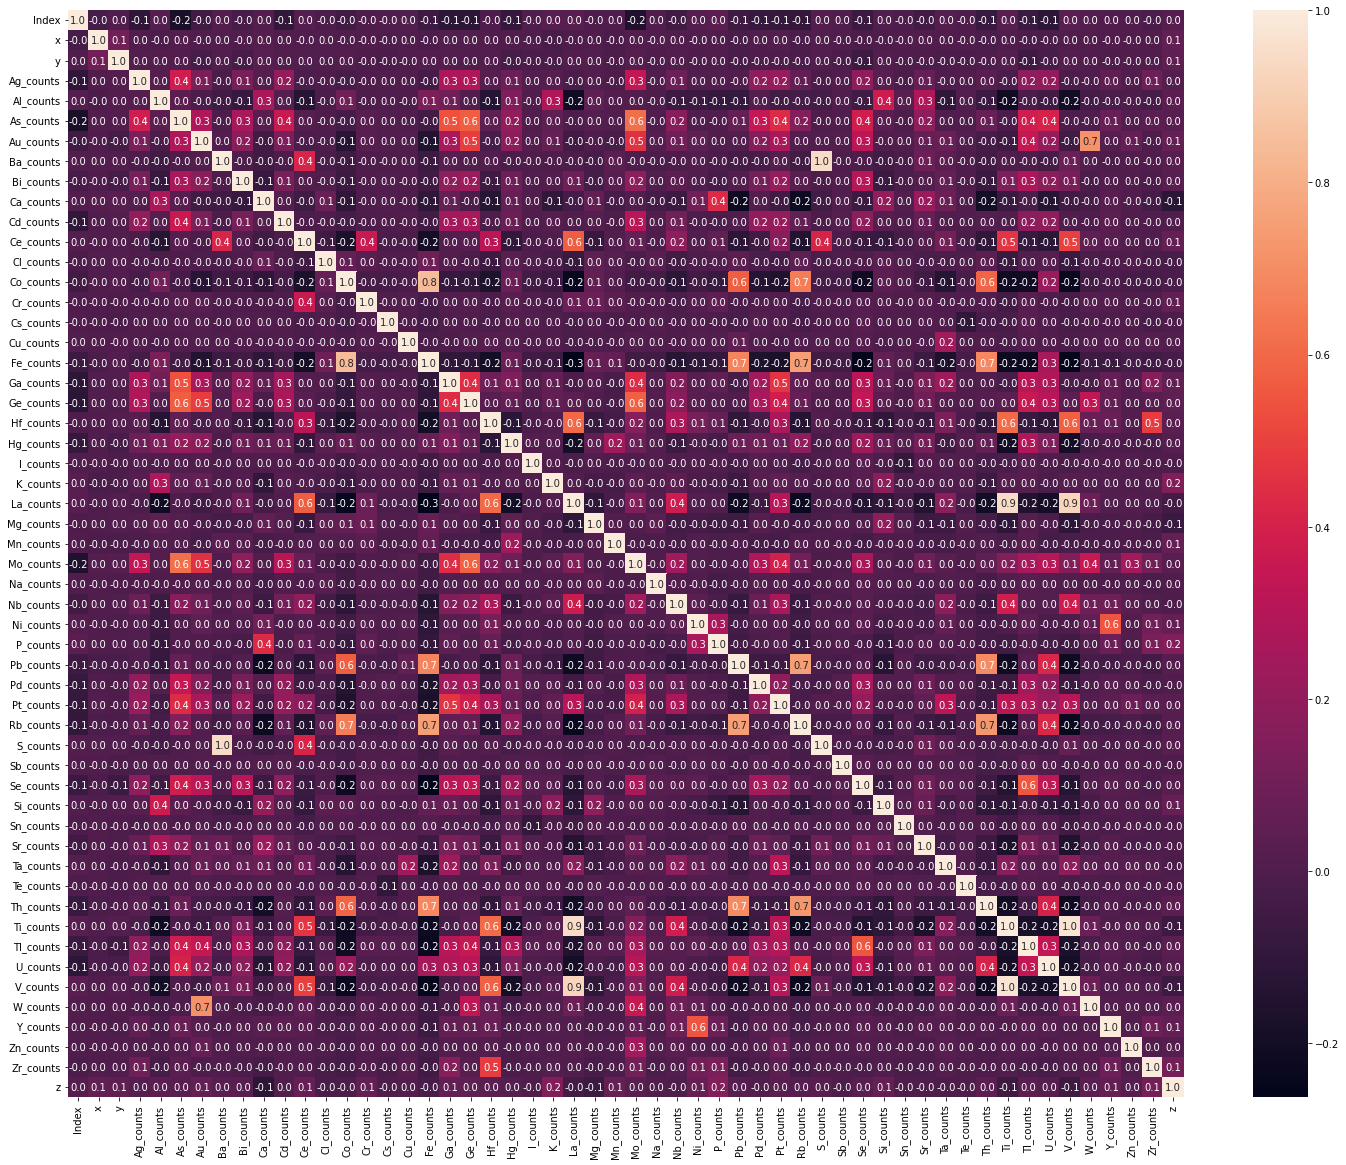

In [17]:
# Correlation of different element counts with mineral names
plt.figure(figsize=(25,20), facecolor='white')
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=True, fmt=".1f")
plt.show()

In [18]:
# Number of NAs
na_counts = train['Mineralogy'].isna().sum()
total_counts = len(train)
print('There are ' + str(na_counts) + ' counts of blank cells (NaN) for a proportion of ' + str(round((na_counts/total_counts)*100,4)) + '% of the train dataset')

There are 49684 counts of blank cells (NaN) for a proportion of 3.8519% of the train dataset


In [19]:
# Showing mineralogy with the least counts
train['Mineralogy'].value_counts().tail(15)

Arsenopyrite           42
Perovskite             38
As oxide               37
Bi phase               33
Pb oxide               30
Zn oxide/carbonate     26
Fe-sulphide            14
Tapiolite (TaNb)       13
Mottramite (CuPbVO)    12
Co-oxide               12
Fe-sulphide_Cu          9
Monazite_Sr             5
CuPbS                   4
CeFe silicate           3
Fe-sulphide_Pb          1
Name: Mineralogy, dtype: int64

### 1.2 Data Cleaning

In [20]:
# Dropping minerals with less than or equal to 10 counts:
counts = train['Mineralogy'].value_counts()
train = train[~train['Mineralogy'].isin(counts[counts <= 10].index)]

In [21]:
# deleting rows with NAs in train dataset:
train.dropna(inplace = True)

In [22]:
# Replace 0.5 with 0 
train = train.replace(0.5, 0)
test = test.replace(0.5, 0)
validation = validation.replace(0.5, 0)

# Drop NA rows
train = train.dropna()
test = test.dropna()
validation = validation.dropna()

# Drop irrelevant columns
train = train.drop('z',axis=1)
train = train.drop('x',axis=1)
train = train.drop('y',axis=1)
train = train.drop('Index',axis=1)
test = test.drop('z',axis=1)
test = test.drop('x',axis=1)
test = test.drop('y',axis=1)
test = test.drop('Index',axis=1)
validation = validation.drop('z',axis=1)
validation = validation.drop('x',axis=1)
validation = validation.drop('y',axis=1)
validation = validation.drop('Index',axis=1)

In [23]:
train.head()

,Ag_counts,Al_counts,As_counts,Au_counts,Ba_counts,Bi_counts,Ca_counts,Cd_counts,Ce_counts,Cl_counts,...,Th_counts,Ti_counts,Tl_counts,U_counts,V_counts,W_counts,Y_counts,Zn_counts,Zr_counts,Mineralogy
0,0.0,20.0,0.0,2.0,0.0,13.0,247.0,0.0,0.0,0.0,...,0.0,2162.0,0.0,4.0,140.0,13.0,12.0,0.0,12.0,Ilmenite
1,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,6.0,3.0,...,13.0,271.0,8.0,9.0,11.0,0.0,0.0,0.0,11.0,Ilmenite
2,1.0,2.0,0.0,0.0,0.0,0.0,16.0,5.0,27.0,0.0,...,0.0,3605.0,0.0,0.0,220.0,30.0,0.0,16.0,7.0,Rutile
3,9.0,0.0,0.0,18.0,0.0,14.0,8.0,0.0,0.0,1.0,...,23.0,20.0,15.0,16.0,0.0,0.0,0.0,0.0,0.0,Fe oxide
4,0.0,12.0,0.0,5.0,9.0,6.0,328.0,0.0,0.0,0.0,...,7.0,69.0,0.0,6.0,6.0,0.0,0.0,0.0,0.0,Epidote


In [24]:
x_train = train.drop(['Mineralogy'],axis=1)
y_train = train['Mineralogy']
y_test = test['Mineralogy']
x_test = test.drop(['Mineralogy'],axis=1)
y_val = validation['Mineralogy']
x_val = validation.drop(['Mineralogy'],axis=1)

### 1.3 Feature Selection

In [25]:
f_p_values=chi2(x_train,y_train)
f_p_values

(array([5.39556596e+04, 3.98480562e+06, 4.80356333e+06, 7.74770106e+06,
        3.48498933e+08, 5.96540595e+06, 1.80327458e+08, 2.43226824e+04,
        4.37008436e+07, 3.39678301e+05, 2.34888988e+07, 5.00216153e+06,
        2.96697044e+03, 4.69467157e+06, 1.01156005e+09, 9.09904245e+05,
        1.10621811e+06, 1.26845839e+07, 8.93681053e+05, 2.76141500e+03,
        2.41267646e+07, 6.43738380e+07, 7.56569333e+05, 5.25559673e+08,
        2.10017996e+06, 1.39317597e+04, 9.70119464e+06, 3.34383843e+06,
        1.31048303e+08, 1.24485775e+07, 1.46834576e+05, 1.39336032e+06,
        7.51180251e+06, 9.19207035e+07, 3.64968624e+03, 2.75065920e+05,
        8.08442778e+06, 9.58749378e+04, 6.95489641e+06, 9.95688208e+06,
        2.02214688e+03, 2.32277557e+07, 1.23229290e+09, 4.06939520e+05,
        8.84191174e+05, 8.03827427e+07, 2.02035728e+08, 1.43577819e+08,
        1.35857950e+08, 1.15459358e+09]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [26]:
for each in range(len(x_train.columns)):
    print(f_p_values[0][each], f_p_values[1][each], x_train.columns[each])

53955.6596319399 0.0 Ag_counts
3984805.6243770113 0.0 Al_counts
4803563.334176731 0.0 As_counts
7747701.057030701 0.0 Au_counts
348498932.5671326 0.0 Ba_counts
5965405.953982875 0.0 Bi_counts
180327458.2583707 0.0 Ca_counts
24322.68242783276 0.0 Cd_counts
43700843.58233179 0.0 Ce_counts
339678.301239604 0.0 Cl_counts
23488898.786737006 0.0 Co_counts
5002161.532374825 0.0 Cr_counts
2966.970437643696 0.0 Cs_counts
4694671.570953156 0.0 Cu_counts
1011560046.6238338 0.0 Fe_counts
909904.2451707041 0.0 Ga_counts
1106218.111767777 0.0 Ge_counts
12684583.881761279 0.0 Hf_counts
893681.0531253797 0.0 Hg_counts
2761.4149965318447 0.0 I_counts
24126764.59629177 0.0 K_counts
64373838.00941673 0.0 La_counts
756569.3327571051 0.0 Mg_counts
525559673.3300234 0.0 Mn_counts
2100179.9620868843 0.0 Mo_counts
13931.759707984285 0.0 Na_counts
9701194.639739996 0.0 Nb_counts
3343838.4296062808 0.0 Ni_counts
131048302.58267266 0.0 P_counts
12448577.488088809 0.0 Pb_counts
146834.57615250492 0.0 Pd_counts
13

In [27]:
f_score=pd.Series(f_p_values[0])
f_score.index=x_train.columns

In [28]:
# F-score is high for all variables, keep all
f_score.sort_values(ascending=False)

Ti_counts    1.232293e+09
Zr_counts    1.154594e+09
Fe_counts    1.011560e+09
Mn_counts    5.255597e+08
Ba_counts    3.484989e+08
W_counts     2.020357e+08
Ca_counts    1.803275e+08
Y_counts     1.435778e+08
Zn_counts    1.358579e+08
P_counts     1.310483e+08
S_counts     9.192070e+07
V_counts     8.038274e+07
La_counts    6.437384e+07
Ce_counts    4.370084e+07
K_counts     2.412676e+07
Co_counts    2.348890e+07
Th_counts    2.322776e+07
Hf_counts    1.268458e+07
Pb_counts    1.244858e+07
Ta_counts    9.956882e+06
Nb_counts    9.701195e+06
Si_counts    8.084428e+06
Au_counts    7.747701e+06
Rb_counts    7.511803e+06
Sr_counts    6.954896e+06
Bi_counts    5.965406e+06
Cr_counts    5.002162e+06
As_counts    4.803563e+06
Cu_counts    4.694672e+06
Al_counts    3.984806e+06
Ni_counts    3.343838e+06
Mo_counts    2.100180e+06
Pt_counts    1.393360e+06
Ge_counts    1.106218e+06
Ga_counts    9.099042e+05
Hg_counts    8.936811e+05
U_counts     8.841912e+05
Mg_counts    7.565693e+05
Tl_counts   

## 2. Logistic Regression Classifier

In [29]:
# Define the multinomial logistic regression model
model = LogisticRegression(multi_class = 'multinomial',solver = 'sag')
model.fit(x_train, y_train)

LogisticRegression(multi_class='multinomial', solver='sag')

In [30]:
# Results on validation set
score = model.score(x_val, y_val)
print(score) 

0.715627982089114


In [31]:
# Results on test set
pred = model.predict(x_test)
cm = metrics.confusion_matrix(y_test, pred)

Text(0.5, 1.0, 'Accuracy Score: 0.72')

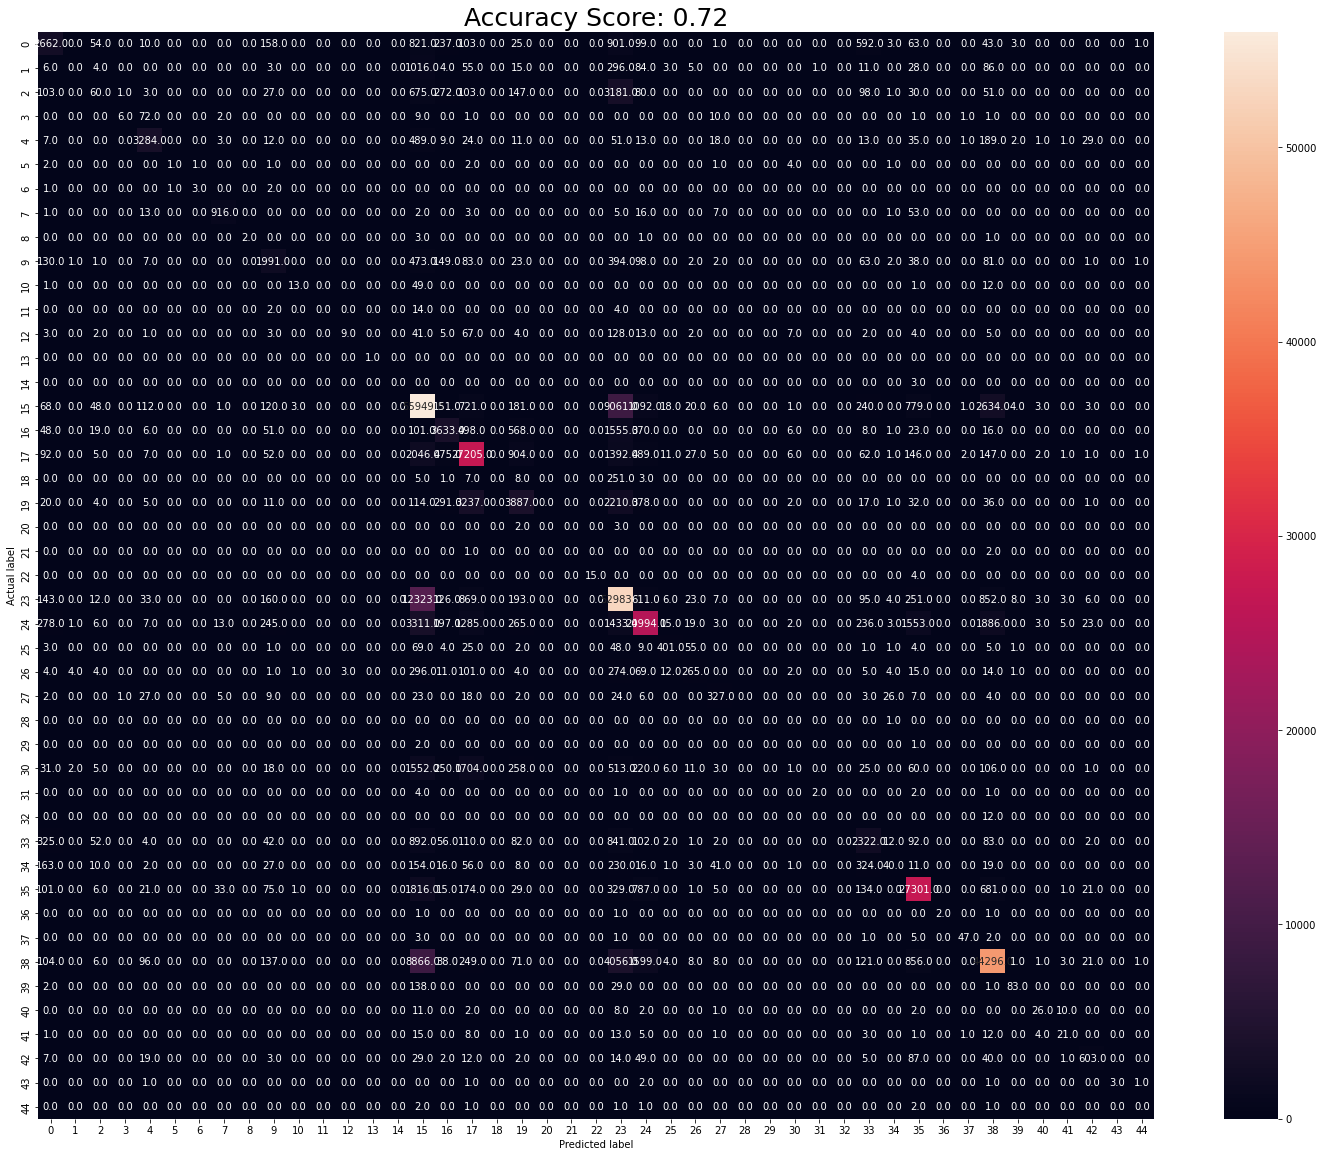

In [32]:
plt.figure(figsize=(25,20), facecolor='white')
sns.heatmap(cm, annot=True, fmt=".1f")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(round(score,2))
plt.title(all_sample_title, size = 25)

In [33]:
print(classification_report(y_test, pred, zero_division=0))

                     precision    recall  f1-score   support

        Al silicate       0.62      0.46      0.53      5776
          Almandine       0.00      0.00      0.00      1617
          Amphibole       0.20      0.01      0.02      4832
           Ancylite       0.75      0.06      0.11       103
            Apatite       0.88      0.78      0.83      4192
       Arsenopyrite       0.50      0.08      0.13        13
           As oxide       0.75      0.43      0.55         7
             Barite       0.94      0.90      0.92      1017
           Bi phase       1.00      0.29      0.44         7
            Biotite       0.63      0.56      0.60      3540
          Carbonate       0.72      0.17      0.28        76
        Cassiterite       0.00      0.00      0.00        20
         Chloritoid       0.75      0.03      0.06       296
           Co-oxide       1.00      1.00      1.00         1
              CuPbS       0.00      0.00      0.00         3
            Epidote    

### 3.1 Top 3 minerals and unknown classification on training set

In [34]:
# Define prediction probability and classes accordingly
pred_prob = list(model.predict_proba(x_train))
classes = list(model.classes_)

In [35]:
# Define prediction probability and classes accordingly
pred_prob = list(model.predict_proba(x_train))
classes = list(model.classes_)

top3_name_prob_all = []
top3_combined_all = []
for i in range(len(pred_prob)):
    name_prob = dict(zip(classes, pred_prob[i]))
    # Extract top 3 probability and their classes
    c = Counter(name_prob)
    top3_name_prob = c.most_common(3)
    top3_name_prob = dict(top3_name_prob)
    # Extract top 3 classes and their combined probability
    top3_combined_prob = sum(top3_name_prob.values())
    top_3_minerals = list(top3_name_prob.keys())
    top_3_mineral = " "
    for minerals in top_3_minerals:
        top_3_mineral += "(" + minerals + ")"
    top3_combined = {}
    top3_combined[top_3_mineral] = top3_combined_prob
    # Replace classes into unknown if combined probability is below 50%
    for i in top3_combined.values():
        if i < 0.5:
            if top_3_mineral in top3_combined:
                del top3_combined[top_3_mineral]
            top3_combined["Unknown"] = top3_combined_prob
    top3_name_prob_all.append(top3_name_prob.copy())
    top3_combined_all.append(top3_combined.copy()) 


In [36]:
train["top3_name_prob_all_df"] = pd.Series(top3_name_prob_all, index = train.index[:len(top3_name_prob_all)])
train["top3_combined_all_df"] = pd.Series(top3_combined_all, index = train.index[:len(top3_name_prob_all)])
#train.to_csv("top3_combined_Probability", encoding='utf-8')
train

,Ag_counts,Al_counts,As_counts,Au_counts,Ba_counts,Bi_counts,Ca_counts,Cd_counts,Ce_counts,Cl_counts,...,Tl_counts,U_counts,V_counts,W_counts,Y_counts,Zn_counts,Zr_counts,Mineralogy,top3_name_prob_all_df,top3_combined_all_df
0,0.0,20.0,0.0,2.0,0.0,13.0,247.0,0.0,0.0,0.0,...,0.0,4.0,140.0,13.0,12.0,0.0,12.0,Ilmenite,"{'Titanite': 0.3508362591099948, 'Rutile': 0.3...",{' (Titanite)(Rutile)(Ilmenite)': 0.9992613935...
1,0.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,6.0,3.0,...,8.0,9.0,11.0,0.0,0.0,0.0,11.0,Ilmenite,"{'Titanite': 0.2095878784990521, 'Rutile': 0.1...",{' (Titanite)(Rutile)(Epidote)': 0.55603746945...
2,1.0,2.0,0.0,0.0,0.0,0.0,16.0,5.0,27.0,0.0,...,0.0,0.0,220.0,30.0,0.0,16.0,7.0,Rutile,"{'Rutile': 0.9834400271992282, 'Titanite': 0.0...",{' (Rutile)(Titanite)(Ilmenite)': 0.9999903571...
3,9.0,0.0,0.0,18.0,0.0,14.0,8.0,0.0,0.0,1.0,...,15.0,16.0,0.0,0.0,0.0,0.0,0.0,Fe oxide,"{'Fe oxide': 0.7803511640283652, 'Hornblende':...",{' (Fe oxide)(Hornblende)(Epidote)': 0.9338110...
4,0.0,12.0,0.0,5.0,9.0,6.0,328.0,0.0,0.0,0.0,...,0.0,6.0,6.0,0.0,0.0,0.0,0.0,Epidote,"{'Epidote': 0.6216221375195118, 'Titanite': 0....",{' (Epidote)(Titanite)(Hornblende)': 0.9471942...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289836,0.0,3.0,0.0,5.0,1.0,17.0,0.0,0.0,0.0,6.0,...,25.0,14.0,0.0,0.0,11.0,4.0,6.0,Fe oxide,"{'Epidote': 0.17381031274633077, 'Hornblende':...",{'Unknown': 0.4868782784148089}
1289837,0.0,5.0,0.0,3.0,0.0,10.0,0.0,0.0,18.0,0.0,...,13.0,8.0,103.0,9.0,0.0,0.0,5.0,Titanite,"{'Rutile': 0.9265301753834735, 'Ilmenite': 0.0...",{' (Rutile)(Ilmenite)(Titanite)': 0.9932041206...
1289838,2.0,12.0,17.0,13.0,0.0,28.0,670.0,16.0,0.0,0.0,...,21.0,19.0,27.0,0.0,12.0,0.0,21.0,Titanite,"{'Titanite': 0.6874538282861177, 'Hornblende':...",{' (Titanite)(Hornblende)(Epidote)': 0.9988082...
1289839,0.0,14.0,0.0,0.0,0.0,0.0,324.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Hornblende,"{'Hornblende': 0.8644605336000447, 'Epidote': ...",{' (Hornblende)(Epidote)(Titanite)': 0.9289616...


### 3.2 Top 3 minerals and unknown classification on test set


In [37]:
# Define prediction probability and classes accordingly
pred_prob = list(model.predict_proba(x_test))
classes = list(model.classes_)
top3_name_prob_all = []
top3_combined_all = []
for i in range(len(pred_prob)):
    name_prob = dict(zip(classes, pred_prob[i]))
    # Extract top 3 probability and their classes
    c = Counter(name_prob)
    top3_name_prob = c.most_common(3)
    top3_name_prob = dict(top3_name_prob)
    top3_name_prob_rounded = {}
    for key in top3_name_prob.keys():
        top3_name_prob_rounded[key] = round(top3_name_prob[key], 4)
    # Extract top 3 classes and their combined probability
    top3_combined_prob = sum(top3_name_prob_rounded.values())
    top3_combined_prob = float(top3_combined_prob)
    top3_combined_prob = round(top3_combined_prob,4)
    top_3_minerals = list(top3_name_prob.keys())
    top_3_mineral = " "
    for minerals in top_3_minerals:
        top_3_mineral += "(" + minerals + ")"
    top3_combined = {}
    top3_combined[top_3_mineral] = top3_combined_prob
    # Replace classes into unknown if combined probability is below 50%
    for i in top3_combined.values():
        if i < 0.5:
            if top_3_mineral in top3_combined:
                del top3_combined[top_3_mineral]
            top3_combined["Unknown"] = top3_combined_prob
    top3_name_prob_all.append(top3_name_prob_rounded.copy())
    top3_combined_all.append(top3_combined.copy())

In [38]:
test["top3_name_prob_all_df"] = pd.Series(top3_name_prob_all, index = test.index[:len(top3_name_prob_all)])
test["top3_combined_all_df"] = pd.Series(top3_combined_all, index = test.index[:len(top3_name_prob_all)])
#test.to_csv("top3_combined_Probability_testset", encoding='utf-8')
test

,Ag_counts,Al_counts,As_counts,Au_counts,Ba_counts,Bi_counts,Ca_counts,Cd_counts,Ce_counts,Cl_counts,...,Tl_counts,U_counts,V_counts,W_counts,Y_counts,Zn_counts,Zr_counts,Mineralogy,top3_name_prob_all_df,top3_combined_all_df
0,2.0,6.0,0.0,1.0,0.0,10.0,620.0,0.0,2.0,7.0,...,0.0,0.0,70.0,0.0,2.0,0.0,8.0,Titanite,"{'Titanite': 0.9144, 'Epidote': 0.0809, 'Hornb...",{' (Titanite)(Epidote)(Hornblende)': 0.9982}
1,4.0,18.0,0.0,2.0,0.0,0.0,312.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,Hornblende,"{'Hornblende': 0.7234, 'Epidote': 0.0898, 'Amp...",{' (Hornblende)(Epidote)(Amphibole)': 0.8676}
2,4.0,20.0,0.0,0.0,0.0,0.0,609.0,0.0,0.0,2.0,...,4.0,2.0,2.0,0.0,2.0,0.0,0.0,Epidote,"{'Epidote': 0.5717, 'Titanite': 0.3191, 'Hornb...",{' (Epidote)(Titanite)(Hornblende)': 0.9947}
3,3.0,5.0,0.0,2.0,0.0,4.0,2.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,Fe oxide,"{'Fe oxide': 0.2014, 'Fe-silicate': 0.1277, 'H...",{'Unknown': 0.4544}
4,1.0,6.0,0.0,0.0,0.0,0.0,305.0,2.0,0.0,2.0,...,5.0,16.0,0.0,0.0,3.0,0.0,0.0,Hornblende,"{'Hornblende': 0.8672, 'Epidote': 0.0404, 'Fe-...",{' (Hornblende)(Epidote)(Fe-silicate)': 0.9335}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368521,1.0,5.0,0.0,0.0,0.0,14.0,70.0,0.0,21.0,1.0,...,0.0,0.0,94.0,0.0,0.0,0.0,11.0,Ilmenite,"{'Ilmenite': 0.9452, 'Titanite': 0.0383, 'Ruti...",{' (Ilmenite)(Titanite)(Rutile)': 0.9955}
368522,0.0,6.0,0.0,2.0,0.0,0.0,21.0,0.0,121.0,0.0,...,0.0,0.0,401.0,0.0,0.0,0.0,0.0,Rutile,"{'Rutile': 0.9974, 'Titanite': 0.0013, 'Ilmeni...",{' (Rutile)(Titanite)(Ilmenite)': 1.0}
368523,10.0,23.0,18.0,20.0,0.0,27.0,946.0,6.0,0.0,4.0,...,10.0,17.0,96.0,0.0,21.0,4.0,31.0,Titanite,"{'Titanite': 0.9867, 'Epidote': 0.0123, 'Hornb...",{' (Titanite)(Epidote)(Hornblende)': 1.0}
368524,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,6.0,...,1.0,0.0,21.0,0.0,0.0,0.0,0.0,Hornblende,"{'Fe oxide': 0.2546, 'Hornblende': 0.1579, 'Il...",{' (Fe oxide)(Hornblende)(Ilmenite)': 0.5265}


### 3.3 Rounding 

In [39]:
# Combine the probability and classes into dictionary
name_prob = dict(zip(classes, pred_prob[1]))

# Extract top 3 probability and their classes with rounding to 4 decimal places
c = Counter(name_prob)
top3_name_prob = c.most_common(3)
top3_name_prob = dict(top3_name_prob)
top3_name_prob_rounded = {}
for key in top3_name_prob.keys():
    top3_name_prob_rounded[key] = round(top3_name_prob[key], 4)
# Extract top 3 classes and their combined probability
top3_combined_prob = sum(top3_name_prob_rounded.values())
top_3_minerals = list(top3_name_prob.keys())
top_3_mineral = " "
for minerals in top_3_minerals:
    top_3_mineral += "(" + minerals + ")"
top3_combined = {}
top3_combined[top_3_mineral] = top3_combined_prob

# Replace classes into unknown if combined probability is below 50%
for i in top3_combined.values():
    if i < 0.5:
        if top_3_mineral in top3_combined:
            del top3_combined[top_3_mineral]
        top3_combined["Unknown"] = top3_combined_prob
print(top3_combined)
print(top3_name_prob_rounded)

{' (Hornblende)(Epidote)(Amphibole)': 0.8676}
{'Hornblende': 0.7234, 'Epidote': 0.0898, 'Amphibole': 0.0544}
